## Extract bubble from simulations

In [1]:
import os,sys
sys.path.append('./bubbles_codes/')
from plotting import *
from bubble_tools import *
from experiment import *


In [2]:
tmp = 0
temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
exp_params = np.asarray([nLat, lamb, phi0, temp])


In [3]:
# standardize plots
lsl = lambda tmp: ('--' if tmp==0 else '-' if tmp==1 else '-.' if tmp==2 else ':')


In [14]:
if False:
    sims_decayed = np.load(sims_decayed_file(*exp_params, minSim, maxSim, nTimeMAX))
    for sim in range(minSim, maxSim):
        if sim not in sims_decayed[:,0]: continue

        path2sim = sim_location(*exp_params, sim)
        real, _ = get_realisation(nLat, sim, path2sim, 2, phieq)
        nC, nT, nN = np.shape(real)

        path2CLEANsim = clean_sim_location(*exp_params, sim)
        real, sim, tdecay, tdecfortran, outcome = np.load(path2CLEANsim)
        bubble = real[0]
        nN, nT = np.shape(bubble)
        simple_imshow(bubble, [0,nN,0,nT], 'Simulation '+str(sim))
        print(outcome, tdecay, tdecfortran)


30


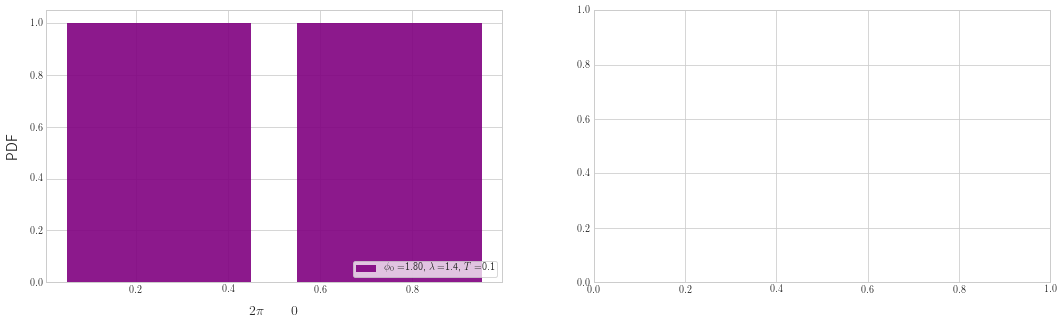

In [15]:
# Classify decays
fig, ax = plt.subplots(1,len(tempList)+1, figsize = (18,5))
plt.style.use('seaborn-whitegrid') # nice and clean grid
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])

for tmp in range(len(tempList)):
    temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    undecayed_sims = np.load(sims_notdecayed_file(*exp_params, minSim, maxSim, nTimeMAX))
    decayed_sims = np.load(sims_decayed_file(*exp_params, minSim, maxSim, nTimeMAX))
    decay_times = np.load(decay_times_file(*exp_params, minSim, maxSim, nTimeMAX))

    outcomes = decayed_sims[:,1]; print(len(outcomes))

    labs = labl(lamb, phi0, temp)
    ax[tmp].hist(outcomes, density=True, bins=2, rwidth=0.8, color=next(cols), alpha=0.9, linewidth=0.5, label=labs)
    ax[tmp].set_xlabel(r'$2\pi \quad\quad 0$')
    ax[tmp].set_ylabel('PDF')
    ax[tmp].legend(loc=4, fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
plt.savefig('./data/vacuum_choice.pdf', rasterize=True); plt.show()


In [4]:
bubbleList, velocities_file, instantonList, tmpList, tcritList, encritList = [[]]*6

for tmp in range(len(tempList)):
    temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    bubbleList.append(np.load(average_file(*exp_params)))
    velocitesList.append(np.load(velocities_file(*exp_params)))
    instantonList.append(np.load(instanton_file(*exp_params)))
    tmpList.append(tmp)
    tcritList.append(np.load(crittimes_file(*exp_params)))
    encritList.append(np.load(critenerg_file(*exp_params)))

In [16]:
def lin_fit_times(times,num,tmin,tmax):
    """
    Given a collection of decay times, do a linear fit to
    the logarithmic survival probability between given times
    
    Input
      times : array of decay times
      num   : original number of samples
      tmin  : minimum time to fit inside
      tmax  : maximum time to fit inside
    """
    t = np.sort(times)
    p = survive_prob(times, num)
    ii = np.where( (t>tmin) & (t<tmax) )
    return np.polyfit(t[ii],np.log(p[ii]), deg=1)


# To do: Debug more to ensure all offsets are correct.
# I've done a first go through and I think they're ok
def survive_prob(t_decay, num_samp):
    """
    Return the survival probability as a function of time.

    Input:
      t_decay  : Decay times of trajectories
      num_samp : Total number of samples in Monte Carlo

    Note: Since some trajectories may not decay, t_decay.size isn't always num_sampe

    Output:
      prob     : Survival Probability

    These can be plotted as plt.plot(t_sort,prob) to get a survival probability graph.
    """
    frac_remain = float(num_samp-t_decay.size)/float(num_samp)
    prob = 1. - np.linspace(1./num_samp, 1.-frac_remain, t_decay.size, endpoint=True)
    return prob

def get_line(dataset, slope, offset):
    return dataset * slope + offset
 

fit params: [-1.06494940e-04 -6.78042963e-01] , # bubbles: 30
fit params: [-1.06483106e-04 -6.78600016e-01] , # bubbles: 30


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


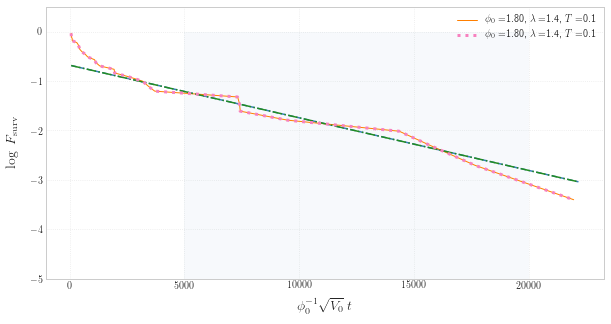

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
for tmp in range(len(tempList)):
    temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    path = decay_times_file(*exp_params, minSim, maxSim, nTimeMAX)
    if os.path.exists(path):
        for zi in [1, 2]:
            decay_times = np.load(path)[:,zi]*dx
            decay_times = np.sort(decay_times)
            ndcys = len(decay_times)

            tmin = 5000
            tmax = 20000

            jfit_times = lin_fit_times(decay_times, ndcys, tmin, tmax)
            print('fit params:', jfit_times, ', # bubbles:', ndcys)

            labs = labl(lamb, phi0, temp)
            ax.plot(decay_times, get_line(decay_times, *jfit_times), ls=['--','-.'][zi-1])
            ax.plot(decay_times, np.log(survive_prob(decay_times, ndcys)), ls=['-',':'][zi-1], linewidth=[1,3][zi-1], label=labs)

plt.fill_betweenx(np.linspace(0, -5, ndcys), np.ones(ndcys)*tmin, np.ones(ndcys)*tmax, alpha=0.04)

ax.set_ylim((-5,0.5))
ax.set_ylabel(r'$\log \; F_{\rm surv}$')
ax.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; t$')
ax.legend()
plt.grid(True, ls=':', color='lightgray', alpha=0.5)
plt.savefig('./data/vacuum_decayrates.pdf')
plt.show()

(90, 2)
[1 1 1 4 4 4 6 6 6 7 7 7 8 8 8 11 11 11 12 12 12 13 13 13 14 14 14 15 15
 15 16 16 16 17 17 17 18 18 18 20 20 20 23 23 23 25 25 25 27 27 27 28 28
 28 29 29 29 30 30 30 33 33 33 35 35 35 40 40 40 42 42 42 43 43 43 44 44
 44 45 45 45 46 46 46 47 47 47 49 49 49]
(115,)


IndexError: invalid index to scalar variable.

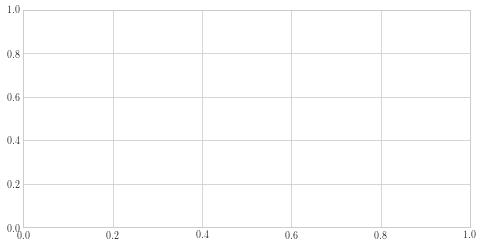

In [31]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
for tmp in range(len(tempList)):
    temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    path = powspec_tlist_file(*exp_params, minSim, maxSim)
    if os.path.exists(path):
        ALL_powspec = np.load(path)

        tlist = ALL_powspec[0]
        simList = ALL_powspec[1][:,0]
        print(np.shape(ALL_powspec[1]))
        print(simList)

        psData = ALL_powspec[1][:,1]
        psData = psData[0] # 0 for field, 1 for conjugate momentum

        print(np.shape(psData)) # simulations, # times, # k modes

        avPSdata = np.nanmean(psData, axis=0)

        # modes to plot:
        aa = 0
        bb = knyq//4

        labs = labl(lamb, phi0, temp)
        for tind, tt in enumerate(tlist):
            if tind%5==0:
                plt.plot(klist[aa:bb], avPSdata[tind][aa:bb], label=labs+', t='+str(tt), ls=lsl(tmp))

        psth = pspec(lamb, phi0, temp)[aa:bb]
        plt.plot(klist[aa:bb], psth, ls=lsl(tmp), label='prediction')

#plt.yscale('log')
plt.legend()
plt.savefig('./data/powspec_evolution'+batch_params(*exp_params)+'.pdf')
plt.show()

Sims in total: 2000
(31, 2000, 2048)
29
1.4 2.243994752564138 0.13


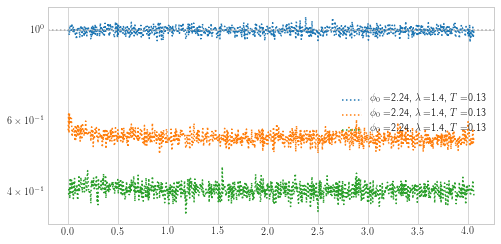

In [85]:
if False:
    fig, ax = plt.subplots(1,1, figsize = (8,4))
    for tmp, temp in enumerate(tempList):
        if tmp!=2: continue

        lamb = lambList[tmp]
        if os.path.exists(pspec_path(lamb, phi0, temp)+'.npy'):
            fftdata = np.load(pspec_path(lamb, phi0, temp)+'.npy')
            print('Sims in total:', len(fftdata))

            simavfftdata = np.empty((len(tlist), len(fftdata), nLat)); print(np.shape(simavfftdata))
            tMax = 0
            for sind in range(len(fftdata)):
                for tind, tt in enumerate(tlist):
                    try:
                        simavfftdata[tind,sind,:] = fftdata[sind][tind]
                    except:
                        if tind-1 > tMax:
                            tMax = tind-1
                        break
            simavfftdata = np.mean(simavfftdata, axis=1)
            print(tMax)

            aa = 1
            bb = knyq-1
            allps = np.nanmean(simavfftdata, axis=0)[aa:bb]
            klist2plot = klist[aa:bb]

            print(lamb, phi0, temp)
            psth = pspec(lamb, phi0, temp)[aa:bb]#*w2(lamb)[aa:bb]

            labs = labl(lamb, phi0, temp)
            for tind, tt in enumerate(tlist):
                if tind%10==0 and tind<=tMax:
                    plt.plot(klist2plot, simavfftdata[tind][aa:bb]/psth, label=labs+', t='+str(tt), ls=lsl(tmp))

         #   plt.plot(klist2plot, allps/psth, label='average', ls=lsl(tmp))
    plt.axhline(1., ls=':', color='darkgray')
    plt.legend()
    #plt.ylim((0,2))
    plt.yscale('log')
    plt.savefig('./data/powspec_evolution'+batch_params(*exp_params)+'.pdf')
    plt.show()

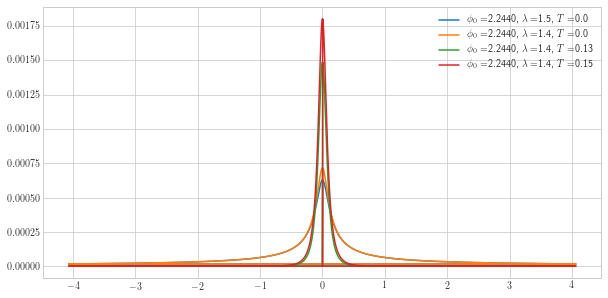

In [86]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
for tmp in range(len(tempList)):
    temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    plt.plot(klist, pspec(lamb, phi0, temp), ls=lsl(tmp), label=labl(lamb, phi0, temp)) # th pow spec
plt.legend(); plt.show()

In [87]:
if False:
    for tmp, temp in enumerate(tempList):
        lamb = lambList[tmp]
        if os.path.exists(en_path(lamb, phi0, temp)+'.npy'):
            energy_data = np.load(en_path(lamb, phi0, temp)+'.npy')
            print('Sims in total:', len(energy_data))

            for sim, energy in enumerate(energy_data):
                if sim%500==0:
                    try:
                        print('sim', sim, 'temp', temp, 'initial energy', energy[0], 'final energy', energy[-1], 'std', np.std(energy))

                        plt.plot(energy, label='total')
                        plt.legend(); plt.show()
                    except:
                        print(energy)
                        continue